In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline

#input, times weight, add a bias, activate 

In [2]:
# CONSTANTS

In [3]:
num_inputs = 2

In [4]:
num_neurons = 3 

In [5]:
# PLACEHOLDERS 

In [6]:
x0 = tf.placeholder(tf.float32, [None, num_inputs])

In [7]:
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [8]:
# VARIABLES 

In [9]:
Wx = tf.Variable(tf.random_normal(shape=[num_inputs, num_neurons]))

In [10]:
Wy = tf.Variable(tf.random_normal(shape=[num_neurons, num_neurons]))

In [11]:
b = tf.Variable(tf.zeros([1,num_neurons]))

In [12]:
# GRAPHS 

In [13]:
y0 = tf.tanh(tf.matmul(x0,Wx) + b)

In [14]:
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1,Wx) + b)

In [15]:
init = tf.global_variables_initializer()

In [16]:
# CREATE DATA

In [17]:
#t=0
x0_batch = np.array([[0,1], [2,3], [4,5]])

#t=1
x1_batch = np.array([[100,101], [102,103], [104,105]])


In [18]:
with tf.Session() as sess:
    
    sess.run(init)
    
    y0_output_vals , y1_output_vals = sess.run([y0,y1], feed_dict={x0:x0_batch, x1:x1_batch})

In [19]:
y0_output_vals

array([[-0.52767223,  0.48457235, -0.63475835],
       [-0.96961391,  0.78340238, -0.8923862 ],
       [-0.9984616 ,  0.9184916 , -0.97146499]], dtype=float32)

In [20]:
y1_output_vals

array([[-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]], dtype=float32)

In [21]:
Wx

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>

# Vanishing Gradients: LSTM and GRU 

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab random starting point for each batch 
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create batch time series on the x axis 
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step 
        y_batch = np.sin(batch_ts)
        
        # FORMATTING for  RNN 
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) , batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)
        

In [14]:
ts_data = TimeSeriesData(250,0,10)

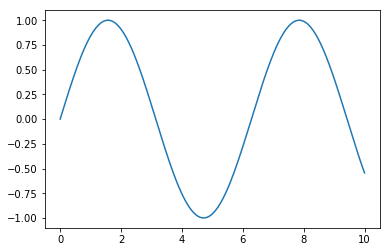

In [15]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [16]:
num_time_steps = 30

In [17]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

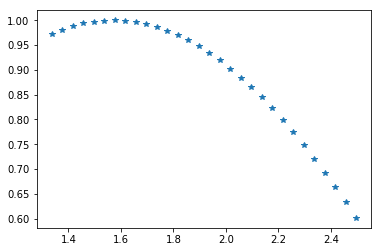

In [18]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

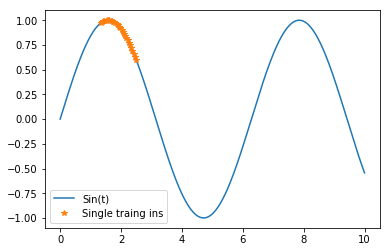

In [19]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*', label='Single traing ins')

plt.legend()

# Training data

In [20]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [21]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

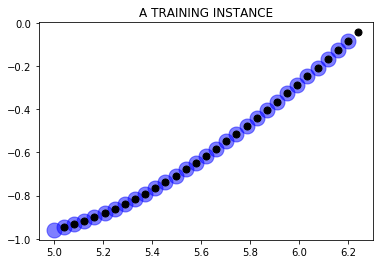

In [22]:
plt.title('A TRAINING INSTANCE')

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='instance')

plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='Target')

# Creating the model

In [23]:
tf.reset_default_graph()

In [24]:
num_inputs = 1 

In [25]:
num_neurons = 100 

In [26]:
num_outputs = 1

In [27]:
learning_rate = 0.0001

In [28]:
num_train_iterations = 2000

In [29]:
batch_size = 1

In [30]:
# PLACEHOLDERS

In [31]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])

In [32]:
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [33]:
# RNN CELL LAYER

In [35]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu),
    output_size=num_outputs
)

In [36]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [37]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [39]:
train = optimizer.minimize(loss)

In [40]:
init = tf.global_variables_initializer()

In [41]:
# SESSION 

In [42]:
saver = tf.train.Saver()

In [44]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        
        sess.run(train,feed_dict = {X:X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
            
        saver.save(sess,"./rnn_time_series_model_code_wout_20170601")

0 	MSE 0.379563
100 	MSE 0.174732
200 	MSE 0.0332572
300 	MSE 0.0267605
400 	MSE 0.0287928
500 	MSE 0.0244811
600 	MSE 0.000621459
700 	MSE 0.0119673
800 	MSE 0.00463143
900 	MSE 0.00310061
1000 	MSE 0.00346859
1100 	MSE 0.0171087
1200 	MSE 0.0144975
1300 	MSE 0.0019156
1400 	MSE 0.0110928
1500 	MSE 0.00189101
1600 	MSE 0.0115754
1700 	MSE 0.000768938
1800 	MSE 0.00925523
1900 	MSE 0.000183633


In [47]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_code_wout_20170601")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_code_wout_20170601


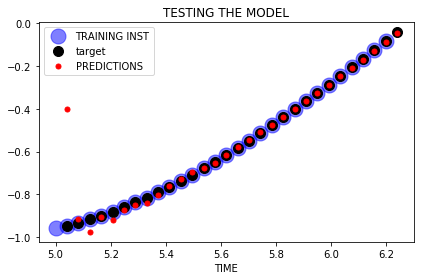

In [49]:
plt.title("TESTING THE MODEL")

#TRAINING INSTANCE
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label='TRAINING INST')

plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='target')

plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label = 'PREDICTIONS')

plt.xlabel('TIME')

plt.legend()

plt.tight_layout()